In [1]:
!pip install pandas scikit-learn matplotlib seaborn wordcloud transformers torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, logging
logging.set_verbosity_error()

In [3]:
# Load dataset
df = pd.read_csv("reddit_depression_dataset.csv", low_memory=False)
print(df.columns)

Index(['Unnamed: 0', 'subreddit', 'title', 'body', 'upvotes', 'created_utc',
       'num_comments', 'label'],
      dtype='object')


In [4]:
df.dropna(subset=["body", "label"], inplace=True)
df['label'] = df['label'].astype(int)
df = df.sample(n=1000, random_state=42).reset_index(drop=True)
print(f"Dataset reduced to: {len(df)} samples")

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.lower().strip()
df['clean_text'] = df['body'].apply(clean_text)


Dataset reduced to: 1000 samples


In [5]:
# TF-IDF + SVM
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
svm_preds = svm_model.predict(X_test_vec)
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       154
           1       0.79      0.72      0.75        46

    accuracy                           0.89       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.89      0.89      0.89       200



In [6]:
!pip install --upgrade accelerate
!pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
# ✅ Dataset class
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = list(labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# ✅ Load tokenizer and data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = DepressionDataset(X_train, y_train, tokenizer)
test_dataset = DepressionDataset(X_test, y_test, tokenizer)

# ✅ Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# ✅ Training arguments (simplified for compatibility)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)

# ✅ Define metric function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': (preds == p.label_ids).mean()}

# ✅ Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# ✅ Evaluate
predictions = trainer.predict(test_dataset)
bert_preds = np.argmax(predictions.predictions, axis=1)

# ✅ Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, bert_preds))

C:\Users\Shreyas\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 569.0586, 'train_samples_per_second': 2.812, 'train_steps_per_second': 0.351, 'train_loss': 0.28728691101074216, 'epoch': 2.0}


C:\Users\Shreyas\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       154
           1       0.84      0.78      0.81        46

    accuracy                           0.92       200
   macro avg       0.89      0.87      0.88       200
weighted avg       0.91      0.92      0.91       200



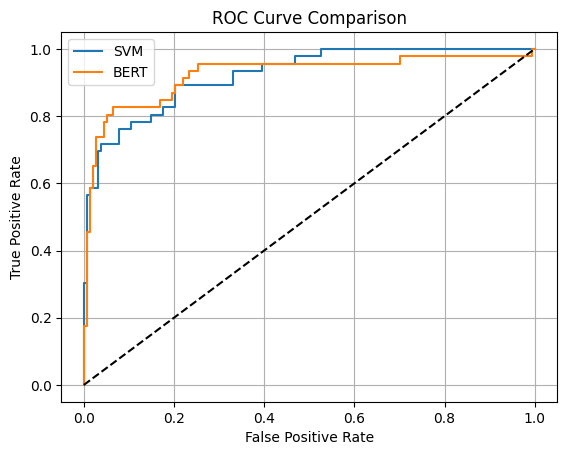

In [8]:
# ROC Curve
svm_probs = svm_model.decision_function(X_test_vec)
bert_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_bert, tpr_bert, _ = roc_curve(y_test, bert_probs)

plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot(fpr_bert, tpr_bert, label='BERT')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Apply TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Vocab Size: {len(vectorizer.get_feature_names_out())}")

TF-IDF Vocab Size: 5000


In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Train model
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
svm_preds = svm_model.predict(X_test_vec)

# Evaluate
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       154
           1       0.79      0.72      0.75        46

    accuracy                           0.89       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.89      0.89      0.89       200



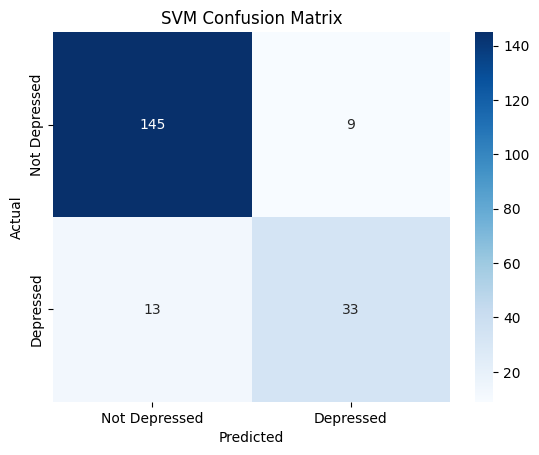

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_mat = confusion_matrix(y_test, svm_preds)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np

# Dataset class
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = list(labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = DepressionDataset(X_train, y_train, tokenizer)
test_dataset = DepressionDataset(X_test, y_test, tokenizer)

# Model and training setup
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs"  # Removed unsupported args for safety
)

# Trainer
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Training and prediction
trainer.train()
predictions = trainer.predict(test_dataset)

# Final predictions
bert_preds = np.argmax(predictions.predictions, axis=1)
bert_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].detach().numpy()



C:\Users\Shreyas\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 563.0619, 'train_samples_per_second': 2.842, 'train_steps_per_second': 0.355, 'train_loss': 0.3177202224731445, 'epoch': 2.0}


C:\Users\Shreyas\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


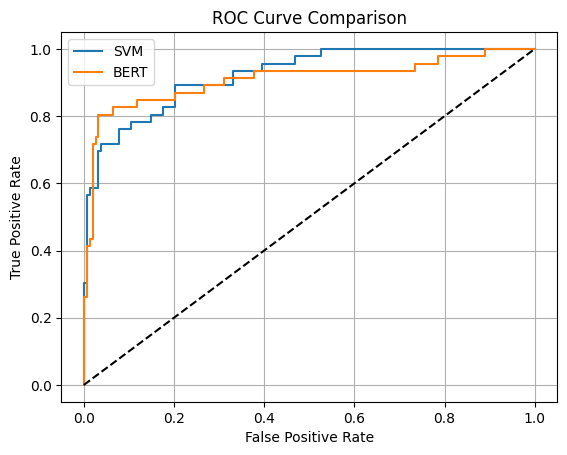

In [13]:
from sklearn.metrics import roc_curve, auc

svm_probs = svm_model.decision_function(X_test_vec)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_bert, tpr_bert, _ = roc_curve(y_test, bert_probs)

plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot(fpr_bert, tpr_bert, label='BERT')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

In [17]:
from wordcloud import WordCloud

depressed_text = " ".join(df[df['label'] == 1]['clean_text'])
non_depressed_text = " ".join(df[df['label'] == 0]['clean_text'])

WordCloud(background_color='black').generate(depressed_text).to_image().show()
WordCloud(background_color='white').generate(non_depressed_text).to_image().show()

In [16]:
from scipy.stats import ttest_ind

bert_correct = (bert_preds == y_test).astype(int)
svm_correct = (svm_preds == y_test).astype(int)
t_stat, p_val = ttest_ind(bert_correct, svm_correct)
print(f"T-test between SVM and BERT: t={t_stat:.3f}, p={p_val:.5f}")

T-test between SVM and BERT: t=0.665, p=0.50620
